In [28]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

BASE = os.path.expanduser("~/Desktop/bonds_project")
DATA = os.path.join(BASE, "data", "market_panel.csv")
OUTP = os.path.join(BASE, "data", "sim_results.parquet")
os.makedirs(os.path.dirname(OUTP), exist_ok=True)

panel = pd.read_csv(DATA, index_col=0, parse_dates=True)
panel = panel[['y_2','y_5','y_10','y_30','IEF','TLT']].dropna().copy()

# We'll calibrate on a trailing window (default ~5y) to reflect current regime
calib_start = panel.index.max() - pd.DateOffset(years=5)
hist = panel.loc[panel.index >= calib_start].copy()
print("Calibration window:", hist.index.min().date(), "→", hist.index.max().date(), "n =", len(hist))


Calibration window: 2020-10-20 → 2025-10-20 n = 1305


In [29]:
def build_curve_from_row(row):
    return {2.0: row['y_2']/100.0, 5.0: row['y_5']/100.0, 10.0: row['y_10']/100.0, 30.0: row['y_30']/100.0}

def interp_zero_rate(curve, t_years):
    ks = np.array(sorted(curve.keys()))
    rs = np.array([curve[k] for k in ks])
    t  = float(np.clip(t_years, ks.min(), ks.max()))
    return float(np.interp(t, ks, rs))

def discount_factor_from_curve(curve, t, comp='cont'):
    r = interp_zero_rate(curve, t)
    if comp == 'cont':   return np.exp(-r*t)
    if comp == 'simple': return 1.0/(1.0 + r*t)
    raise ValueError

def bond_cashflows(T, c, freq=2, face=100.0):
    n = int(round(T*freq))
    times = np.arange(1, n+1, dtype=float)/float(freq)
    times[-1] = T
    cpn = c*face/float(freq)
    cfs = np.full_like(times, cpn, dtype=float); cfs[-1] += face
    return list(zip(times, cfs))

def price_from_curve(curve, T, c, freq=2, face=100.0, comp='cont'):
    pv = 0.0
    for t, cf in bond_cashflows(T, c, freq=freq, face=face):
        pv += cf*discount_factor_from_curve(curve, t, comp=comp)
    return float(pv)

def portfolio_price(curve, bonds, comp='cont'):
    return float(sum(b["q"]*price_from_curve(curve, b["T"], b["c"], freq=b["f"], face=b["F"], comp=comp) for b in bonds))

def portfolio_krdv01s(curve, bonds, comp='cont', bump_bp=1.0, keys=(2.0,5.0,10.0,30.0)):
    P0 = portfolio_price(curve, bonds, comp=comp)
    out = {}
    for k in keys:
        bumped = dict(curve)
        if k not in bumped: bumped[k] = interp_zero_rate(curve, k)
        bumped[k] += bump_bp/10000.0
        P_up = portfolio_price(bumped, bonds, comp=comp)
        out[k] = float((P_up - P0)/(-bump_bp))  # $ per 1bp, per $100
    return out

def bond_spec(T, c, freq=2, face=100.0, qty=1.0):
    return {"T":float(T), "c":float(c), "f":int(freq), "F":float(face), "q":float(qty)}


In [30]:
# === Portfolio (per $100 notional) ===
BONDS = [
    bond_spec(2.0, 0.03, 2, 100.0, 1.0),
    bond_spec(5.0, 0.03, 2, 100.0, 1.0),
    bond_spec(10.0,0.03, 2, 100.0, 1.0),
]

# As-of state (today = last row in panel)
asof = panel.iloc[-1]
curve0 = build_curve_from_row(asof)
P_port0 = portfolio_price(curve0, BONDS)
P_IEF0, P_TLT0 = float(asof['IEF']), float(asof['TLT'])
print("As-of: Portfolio price:", round(P_port0,4), "IEF:", round(P_IEF0,4), "TLT:", round(P_TLT0,4))

# Heuristic ETF KRDs: choose effective durations and splits across keys that sum to 1
def heuristic_etf_krd(effective_duration, current_price, weights):
    dv01 = effective_duration * current_price * 1e-4
    krd = {float(k): float(dv01 * w) for k, w in weights.items()}  # per bp
    return krd, dv01

# Reasonable defaults; tune if you have better vendor facts
KRD_IEF0, DV01_IEF0 = heuristic_etf_krd(
    effective_duration=7.5, current_price=P_IEF0, weights={2:0.05, 5:0.45, 10:0.45, 30:0.05}
)
KRD_TLT0, DV01_TLT0 = heuristic_etf_krd(
    effective_duration=17.0, current_price=P_TLT0, weights={2:0.02, 5:0.18, 10:0.40, 30:0.40}
)
print("IEF DV01:", round(DV01_IEF0,6), "KRD split:", {k: round(v,6) for k,v in KRD_IEF0.items()})
print("TLT DV01:", round(DV01_TLT0,6), "KRD split:", {k: round(v,6) for k,v in KRD_TLT0.items()})


As-of: Portfolio price: 287.9439 IEF: 97.52 TLT: 91.54
IEF DV01: 0.07314 KRD split: {2.0: 0.003657, 5.0: 0.032913, 10.0: 0.032913, 30.0: 0.003657}
TLT DV01: 0.155618 KRD split: {2.0: 0.003112, 5.0: 0.028011, 10.0: 0.062247, 30.0: 0.062247}


In [31]:
# Calibration to daily 10y yield (decimal)
r = (hist['y_10']/100.0).values
rt, rt1 = r[:-1], r[1:]
X = np.column_stack([rt, np.ones_like(rt)])
beta, *_ = np.linalg.lstsq(X, rt1, rcond=None)   # rt1 ≈ phi*rt + c
phi, c = float(beta[0]), float(beta[1])
eps = rt1 - (phi*rt + c)
var_eps = float(np.var(eps, ddof=1))

dt = 1/252.0
# Map to continuous-time Vasicek: r_{t+Δ} = r_t e^{-aΔ} + b(1-e^{-aΔ}) + ε, Var[ε] = σ^2/(2a)*(1-e^{-2aΔ})
a = -np.log(max(phi, 1e-12))/dt
b = c / (1.0 - phi) if abs(1-phi) > 1e-10 else r.mean()
sigma = np.sqrt(var_eps * 2.0*a / (1.0 - np.exp(-2.0*a*dt)))

print("Vasicek params: a=", round(a,4), " b=", round(b,4), " sigma=", round(sigma,4), " (daily dt=1/252)")


Vasicek params: a= 0.64  b= 0.0421  sigma= 0.0096  (daily dt=1/252)


In [32]:
# Build Δy matrix (bp)
dy = hist[['y_2','y_5','y_10','y_30']].diff().dropna()*100.0
X = dy.values
# Standard PCA via SVD
U,S,Vt = np.linalg.svd(X - X.mean(0), full_matrices=False)
# Components (columns): loadings for keys
pcs = Vt.T   # shape (4,4); pc1 = pcs[:,0], pc2 = pcs[:,1]
expl_var = (S**2) / (len(X)-1)
expl_var_ratio = expl_var / expl_var.sum()
print("PCA explained variance ratios:", np.round(expl_var_ratio[:3],4))
pc1, pc2 = pcs[:,0], pcs[:,1]   # level & slope-ish
keys = np.array([2.0,5.0,10.0,30.0])


PCA explained variance ratios: [0.8683 0.1145 0.0139]


In [33]:
rng = np.random.default_rng(42)

def simulate_vasicek_paths(Npaths=500, Nd=252, r0=None):
    """Simulate 10y yield under Vasicek (daily). Returns array (Nd+1, Npaths) in DECIMAL."""
    if r0 is None:
        r0 = float(panel.iloc[-1]['y_10']/100.0)
    r = np.zeros((Nd+1, Npaths), dtype=float)
    r[0,:] = r0
    exp_a_dt = np.exp(-a*dt)
    var_e = (sigma**2)/(2*a)*(1 - np.exp(-2*a*dt))
    for t in range(Nd):
        mean_next = r[t,:]*exp_a_dt + b*(1 - exp_a_dt)
        r[t+1,:] = mean_next + rng.normal(0.0, np.sqrt(var_e), size=Npaths)
    return r

def simulate_keyrates_parallel(Npaths=500, Nd=252):
    """All key rates move with simulated 10y (parallel). Return dict of key→matrix (Nd+1,Npaths) in % (not decimal)."""
    r10 = simulate_vasicek_paths(Npaths, Nd)   # decimal
    # deltas in bp relative to t0
    d10_bp = (r10 - r10[0:1,:]) * 10000.0
    kr = {}
    for k in [2.0,5.0,10.0,30.0]:
        kr[k] = d10_bp.copy()  # same shift everywhere
    return kr

def simulate_keyrates_level_slope(Npaths=500, Nd=252, slope_scale=1.0):
    """
    Combine Vasicek level with stochastic slope from PCA:
      Δy_vec(bp) = α_t * pc1 + β_t * pc2, with α_t from Vasicek increments mapped to bp, β_t ~ N(0, sigma2).
    """
    # Level from Vasicek 10y
    r10 = simulate_vasicek_paths(Npaths, Nd)          # decimal
    d10_bp = np.diff(r10, axis=0) * 10000.0          # per-day change of level in bp
    # Slope volatility from historical PC2
    # Estimate per-day variance along PC2
    Xc = dy.values - dy.values.mean(0, keepdims=True)
    # Project onto PC2 to get daily factor series
    fact2 = Xc.dot(pc2)
    s2 = np.std(fact2, ddof=1)                        # bp units
    # Simulate β_t ~ N(0, s2) scaled
    beta = rng.normal(0.0, s2*slope_scale, size=(Nd, Npaths))
    # Reconstruct Δy(bp) per day: α_t * pc1 + β_t * pc2, where α_t = avg(d10_bp across keys projected on pc1)
    # Use α_t so that avg move near 10y matches Vasicek Δ10y
    # Determine scaling α_t so that pc1's 10y component equals d10_bp_t
    # Compute weights such that pc1 contributes exactly d10_bp on the 10y key:
    idx10 = int(np.where(keys==10.0)[0][0])
    pc1_10 = pc1[idx10]
    alpha = d10_bp / max(pc1_10, 1e-12)  # shape (Nd,Npaths)

    # Build Δy_t for each day
    Delta = np.zeros((Nd, 4, Npaths), dtype=float)  # (time, key_idx, path)
    for i in range(4):
        Delta[:, i, :] = alpha * pc1[i] + beta * pc2[i]

    # Cumulate from 0 with Delta; prepend zeros for t0
    KR = {}
    for i,k in enumerate(keys):
        cum = np.vstack([np.zeros((1, Npaths)), np.cumsum(Delta[:, i, :], axis=0)])
        KR[k] = cum  # in bp from t0
    return KR


In [34]:
def solve_ls_hedge(KRD_port, KRD_I, KRD_T, keys=(2.0,5.0,10.0,30.0)):
    b = np.array([KRD_port.get(k,0.0) for k in keys], dtype=float)
    A = np.column_stack([
        np.array([KRD_I.get(k,0.0) for k in keys], dtype=float),
        np.array([KRD_T.get(k,0.0) for k in keys], dtype=float),
    ])
    h, *_ = np.linalg.lstsq(A, b, rcond=None)  # LONG units: to hedge, we SHORT these
    return h, A, b

def run_mc(KR_paths, Npaths=500, rebal_freq=21):
    """
    KR_paths: dict key->(Nd+1,Npaths) of cumulative bp shifts from t0 (0 at t=0).
    Rebal every ~21 trading days (monthly).
    Returns a DataFrame of daily P&L per path (per $100 notional).
    """
    Nd = list(KR_paths.values())[0].shape[0]-1
    keys = sorted(KR_paths.keys())
    # Starting state
    P_port0 = portfolio_price(curve0, BONDS)
    P_IEF0, P_TLT0 = float(asof['IEF']), float(asof['TLT'])
    # ETF KRDs at t0
    KRD_I0, KRD_T0 = dict(KRD_IEF0), dict(KRD_TLT0)

    recs = []
    for p in range(Npaths):
        # Reset prices
        P_port_prev = P_port0
        P_IEF_prev, P_TLT_prev = P_IEF0, P_TLT0
        h = np.array([0.0, 0.0])  # LONG units (we short to hedge)

        for t in range(1, Nd+1):
            # Build today's curve = base + simulated shift (apply bp/10000 to decimals)
            curve_t = {}
            for k in keys:
                curve_t[k] = curve0[k] + (KR_paths[k][t, p] / 10000.0)

            # Rebalance?
            if t % rebal_freq == 0 or t == 1:
                # Portfolio KRD at today's curve
                KRD_port = portfolio_krdv01s(curve_t, BONDS, keys=keys)
                # Use current ETF prices (we’ll update below)
                # Approximate ETF KRDs fixed at t0 splits but scaled by current price & duration
                P_IEF_curr, P_TLT_curr = P_IEF_prev, P_TLT_prev
                # Keep duration constants (7.5, 17) and scale DV01 with price
                KRD_I = {k: v * (P_IEF_curr / P_IEF0) for k,v in KRD_I0.items()}
                KRD_T = {k: v * (P_TLT_curr / P_TLT0) for k,v in KRD_T0.items()}

                h, A, b = solve_ls_hedge(KRD_port, KRD_I, KRD_T, keys=keys)

            # ONE-DAY PRICE UPDATES
            # Portfolio MTM: reprice directly under curve_t
            P_port_t = portfolio_price(curve_t, BONDS)

            # ETF MTM: update via KRD × daily Δbp (linear)
            d_bp = {k: (KR_paths[k][t, p] - KR_paths[k][t-1, p]) for k in keys}  # today's bp change
            dP_IEF = - sum(KRD_I0[k] * d_bp[k] for k in keys) * (P_IEF_prev / P_IEF0)  # scale by relative price
            dP_TLT = - sum(KRD_T0[k] * d_bp[k] for k in keys) * (P_TLT_prev / P_TLT0)

            P_IEF_t = P_IEF_prev + dP_IEF
            P_TLT_t = P_TLT_prev + dP_TLT

            # P&L
            dP_port  = P_port_t - P_port_prev
            dP_hedge = - (h[0]*dP_IEF + h[1]*dP_TLT)  # SHORT h
            recs.append({"path": p, "t": t, "dPnL_port": dP_port, "dPnL_hedge": dP_hedge, "dPnL_combo": dP_port + dP_hedge})

            # advance
            P_port_prev = P_port_t
            P_IEF_prev, P_TLT_prev = P_IEF_t, P_TLT_t

    out = pd.DataFrame.from_records(recs)
    return out

# Small smoke tests (few paths, short horizon) before full MC
KR_parallel_test = simulate_keyrates_parallel(Npaths=10, Nd=21)
mc_test = run_mc(KR_parallel_test, Npaths=10, rebal_freq=21)
print("Smoke test rows:", len(mc_test), " example:\n", mc_test.head())


Smoke test rows: 210  example:
    path  t  dPnL_port  dPnL_hedge  dPnL_combo
0     0  1  -0.272994    0.256202   -0.016792
1     0  2  -0.771892    0.725240   -0.046652
2     0  3   0.156314   -0.146501    0.009814
3     0  4  -1.858584    1.750608   -0.107976
4     0  5  -0.639467    0.600169   -0.039298


In [35]:
Npaths = 500     
Nd     = 252     # 1y horizon; set 504 for ~2y
rebal  = 21      # monthly re-hedge

# Model A: Parallel
KR_parallel = simulate_keyrates_parallel(Npaths=Npaths, Nd=Nd)
mc_par = run_mc(KR_parallel, Npaths=Npaths, rebal_freq=rebal)
mc_par["model"] = "parallel"

# Model B: Level + Slope
KR_ls = simulate_keyrates_level_slope(Npaths=Npaths, Nd=Nd, slope_scale=1.0)
mc_ls = run_mc(KR_ls, Npaths=Npaths, rebal_freq=rebal)
mc_ls["model"] = "level_slope"

mc = pd.concat([mc_par, mc_ls], ignore_index=True)
mc.to_parquet(OUTP)
print("Saved MC results ->", OUTP, " rows:", len(mc))


Saved MC results -> /Users/oltimyrtaj/Desktop/bonds_project/data/sim_results.parquet  rows: 252000


Parallel model — median metrics:
 AnnVol_unhedged    13.842
AnnVol_hedged       0.850
VarReduction_%     99.619
VaR95_unhedged     -1.427
VaR95_hedged       -0.082
MaxDD_unhedged    -14.766
MaxDD_hedged       -0.746
dtype: float64

Level+Slope model — median metrics:
 AnnVol_unhedged    14.282
AnnVol_hedged       1.062
VarReduction_%     99.441
VaR95_unhedged     -1.461
VaR95_hedged       -0.106
MaxDD_unhedged    -16.517
MaxDD_hedged       -1.034
dtype: float64


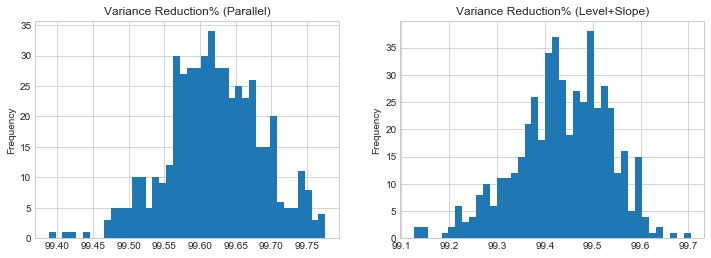

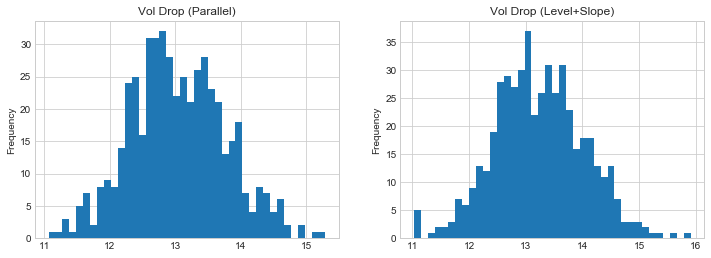

In [36]:
def summarize_mc(df):
    g = df.groupby("path")
    # per-path series
    dU = g["dPnL_port"].sum()    # total PnL
    dH = g["dPnL_combo"].sum()
    volU = g["dPnL_port"].std()*np.sqrt(252)
    volH = g["dPnL_combo"].std()*np.sqrt(252)

    # variance reduction (using variances over daily P&L)
    varU = g["dPnL_port"].var()
    varH = g["dPnL_combo"].var()
    vreduce = 100*(1 - (varH/varU))

    # VaR (simple 1-day, pooled per path)
    def hist_var(x, p=0.95): return float(np.quantile(x.dropna(), 1-p))
    VaR95U = g["dPnL_port"].apply(hist_var, p=0.95)
    VaR95H = g["dPnL_combo"].apply(hist_var, p=0.95)

    # Max drawdown of cumulative P&L
    def max_dd(x):
        c = x.cumsum(); peak = c.cummax(); dd = c - peak; return float(dd.min())
    MDDU = g["dPnL_port"].apply(max_dd)
    MDDH = g["dPnL_combo"].apply(max_dd)

    summary = pd.DataFrame({
        "AnnVol_unhedged": volU,
        "AnnVol_hedged": volH,
        "VarReduction_%": vreduce,
        "VaR95_unhedged": VaR95U,
        "VaR95_hedged": VaR95H,
        "MaxDD_unhedged": MDDU,
        "MaxDD_hedged": MDDH,
    })
    return summary

sum_par = summarize_mc(mc[mc["model"]=="parallel"])
sum_ls  = summarize_mc(mc[mc["model"]=="level_slope"])

print("Parallel model — median metrics:\n", sum_par.median().round(3))
print("\nLevel+Slope model — median metrics:\n", sum_ls.median().round(3))

# Quick plots
fig, ax = plt.subplots(1,2, figsize=(12,4))
sum_par["VarReduction_%"].plot(kind='hist', bins=40, ax=ax[0], title="Variance Reduction% (Parallel)")
sum_ls["VarReduction_%"].plot(kind='hist', bins=40, ax=ax[1], title="Variance Reduction% (Level+Slope)")
plt.show()

fig, ax = plt.subplots(1,2, figsize=(12,4))
(sum_par["AnnVol_unhedged"] - sum_par["AnnVol_hedged"]).plot(kind='hist', bins=40, ax=ax[0], title="Vol Drop (Parallel)")
(sum_ls["AnnVol_unhedged"] - sum_ls["AnnVol_hedged"]).plot(kind='hist', bins=40, ax=ax[1], title="Vol Drop (Level+Slope)")
plt.show()


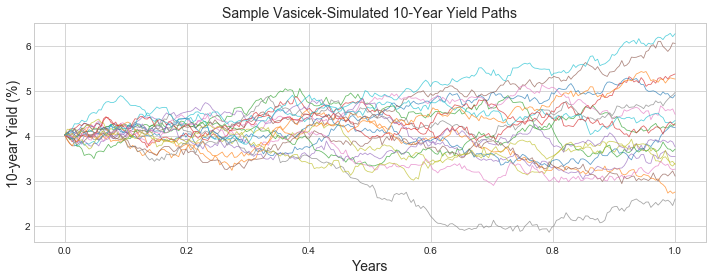

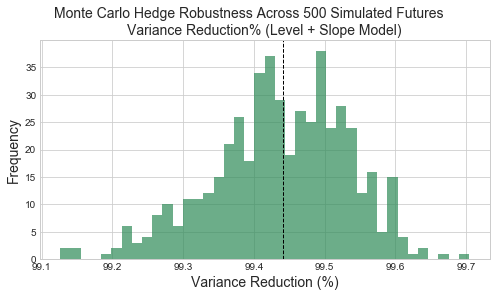

In [41]:
# === Visualization: Vasicek rate paths + Hedge performance ===
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")  # or comment out if unavailable

# 1) Simulated 10-year yield paths (illustrate Vasicek mean reversion)
r10_paths = simulate_vasicek_paths(Npaths=20, Nd=252) * 100  # %
t = np.arange(r10_paths.shape[0]) / 252.0  # years
plt.figure(figsize=(10, 4))
for i in range(r10_paths.shape[1]):
    plt.plot(t, r10_paths[:, i], lw=0.8, alpha=0.7)
plt.xlabel("Years", fontsize=14)
plt.ylabel("10-year Yield (%)", fontsize=14)
plt.title("Sample Vasicek-Simulated 10-Year Yield Paths", fontsize=14)
plt.tight_layout()
plt.show()

# 2) Variance Reduction Histogram for Level + Slope model only
plt.figure(figsize=(7, 4))
sum_ls["VarReduction_%"].plot(kind="hist", bins=40, color="seagreen", alpha=0.7)
plt.title("Variance Reduction% (Level + Slope Model)", fontsize=14)
plt.xlabel("Variance Reduction (%)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.axvline(sum_ls["VarReduction_%"].median(), color="black", ls="--", lw=1)
plt.suptitle("Monte Carlo Hedge Robustness Across 500 Simulated Futures", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()
